# Introducción

En este proyecto construiremos un modelo de aprendizaje automático para realizar análisis de sentimientos, utilizando  un subconjunto de clasificación de texto donde la tarea es detectar si una oración dada es positiva, neutral o negativa, utilizando [PyTorch](https://github.com/pytorch/pytorch) y [torchtext](https://github.com/pytorch/text).


Se utilizará uno de los modelos más básicos para NLP (natural language processing / procesamiento del lenguaje natural): un modelo NBoW (neural bag-of-words / bolsa neuronal de palabras). El modelo NBoW es un modelo básico sólido y de uso común para las tareas de NLP.

![](https://github.com/bentrevett/pytorch-sentiment-analysis/blob/master/assets/nbow_model.png?raw=1)

# Desarrollo del proyecto





## Preparación de datos *

Antes de que implementemos nuestro modelo NBow, primero tenemos que realizar ciertos pasos para tener nuestros datos de la forma idónea.

Los pasos de los que va a constar este proyecto es:
  1. Importar paquetes y módulos
  2. Cargar los datos
  3. "Tokenizar" los datos
  4. Crear las separaciones de datos
  5. Crear un vocabulario
  6. Numerización de datos
  7. Creación de "dataloaders"
  8. Creación de las funciones de entrenamiento y validación
  9. Pruebas de predicción de sentimientos

## Importar paquetes y módulos (1)

Primero vamos a instalar el paquete datasets y después importamos los módulos.


In [ ]:
## en el caso de que no esté instalado datasets:
!pip install datasets

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 474.6/474.6 kB 10.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.5/110.5 kB 11.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 212.5/212.5 kB 18.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.3/134.3 kB 13.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 26.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.5/224.5 kB 17.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.5/114.5 kB 11.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 23.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 149.6/149.6 kB 14.8 MB/s eta 0:00:00


In [ ]:
import functools
import sys
import datasets
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torchtext
import tqdm
import seaborn as sns
import pandas as pd
import re
import math

from torch.utils.data import TensorDataset


In [ ]:
seed = 0

torch.manual_seed(seed)
np.random.seed(seed)

## Cargar los datos (2)



Vamos a cargar los datos, en mi caso es un Excel.

Este excel está ubicado en el repositorio de [GitHub](https://github.com/mariadeljq/SentimentAnalysis) del proyecto.

Lo vamos a leer con el paquete de Pandas y vamos a crear un Dataframe con las columnas de texto y sentimiento

In [ ]:
## para poner mi dataset
#file_path = '/content/drive/MyDrive/sentiment_analysis/dataset.csv' en caso de que queramos usar el .csv
#data_csv = pd.read_csv(file_path)

#fp_xlsx = '/content/drive/MyDrive/sentiment_analysis/dataset.xlsx'
fp_xlsx = 'https://github.com/mariadeljq/SentimentAnalysis/blob/main/dataset.xlsx?raw=1'
data = pd.read_excel(fp_xlsx)


In [ ]:
## vamos a convertir este excel en un DataFrame con las columnas correspondientes
# el archivo Excel tiene columnas 'textID', 'text', 'selected_text' y 'sentiment'
textID = data['Column1'].tolist()
text = data['Column2'].tolist()
selected_text = data['Column3'].tolist()
sentiment = data['Column4'].tolist()

# Crear un nuevo DataFrame con las columnas extraídas
dataset = pd.DataFrame({ # solo queremos estas dos
    'text': text,
    'sentiment' : sentiment,
})

dataset.head()

,text,sentiment
0,text,sentiment
1,"I`d have responded, if I were going",neutral
2,Sooo SAD I will miss you here in San Diego!!!,negative
3,my boss is bullying me...,negative
4,what interview! leave me alone,negative


Comprobamos lo que hemos generado.

Para acceder a los elementos individuales de un DataFrame en pandas, puedes utilizar diferentes métodos según tus necesidades.

* Acceder a un elemento específico por índice de fila y nombre de columna:

    valor = dataset.loc[fil_index, 'nombre_columna']

* Acceder a un elemento específico por índice de fila y posición de columna:

    valor = dataset.iloc[fil_index, col_index]

* Acceder a una fila completa por índice de fila:

    fila = dataset.loc[fil_index]

* Acceder a una columna completa por nombre de columna:

    columna = dataset['nombre_columna']

In [ ]:
# split en train/test split
dataset = dataset[1:] # quitamos la primera fila porque contiene el nombre de las columnas

dataset.iloc[0,0]


' I`d have responded, if I were going'

In [ ]:
## comprobamos que la primera fila con los nombres de las columnas ahora no está como fila
dataset.head()

,text,sentiment
1,"I`d have responded, if I were going",neutral
2,Sooo SAD I will miss you here in San Diego!!!,negative
3,my boss is bullying me...,negative
4,what interview! leave me alone,negative
5,"Sons of ****, why couldn`t they put them on t...",negative


In [ ]:
# Eliminar filas con valores no válidos en la columna 'text'
dataset = dataset.dropna(subset=['text'])
  

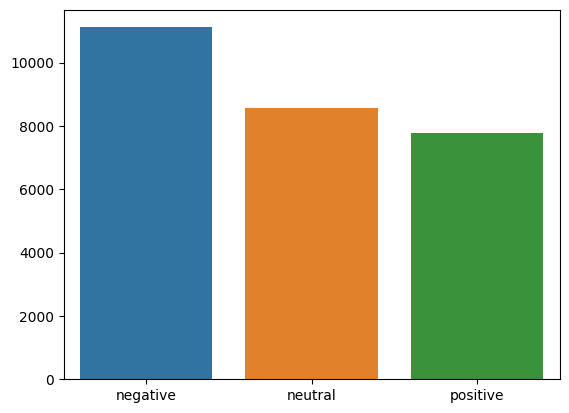

In [ ]:
dd = pd.Series(dataset['sentiment']).value_counts()
sns.barplot(x=np.array(['negative','neutral','positive']),y=dd.values)
plt.show()

Observamos en la distribución de los sentimientos de los textos que hay mas negativos que neutrales, y más neutrales que positivos

## "Tokenizar" los datos (3)


Vamos a tokenizar los datos con un tokenizador de inglés básico.

El proceso de tokenizar los datos consiste en separar las palabras de un texto, quitando signos de puntuación.

In [ ]:
tokenizer = torchtext.data.utils.get_tokenizer("basic_english")

In [ ]:
  tokenizer("Hello world! How are you doing today? I'm doing fantastic!")

['hello',
 'world',
 '!',
 'how',
 'are',
 'you',
 'doing',
 'today',
 '?',
 'i',
 "'",
 'm',
 'doing',
 'fantastic',
 '!']

In [ ]:
# función para que los signos de puntuacion no los ponga en la lista y así evitar informacion indeseada.
def clean_text(text):
    text = re.sub(r'[^\w\s\d]', '', text) 
    # todos los caracteres diferentes de palabras \w o espacio en blanco \s (necesitamos el espacio en blanco para tokenizar)
    # también conservamos números \d
    return text

In [ ]:
dataset['tokens'] = dataset['text'].apply(lambda x: tokenizer(clean_text(x)))

In [ ]:
dataset.head()

,text,sentiment,tokens
1,"I`d have responded, if I were going",neutral,"[id, have, responded, if, i, were, going]"
2,Sooo SAD I will miss you here in San Diego!!!,negative,"[sooo, sad, i, will, miss, you, here, in, san,..."
3,my boss is bullying me...,negative,"[my, boss, is, bullying, me]"
4,what interview! leave me alone,negative,"[what, interview, leave, me, alone]"
5,"Sons of ****, why couldn`t they put them on t...",negative,"[sons, of, why, couldnt, they, put, them, on, ..."


## Crear las separaciones de datos (4)



De todo el contenido de datos, vamos a separarlos en tres partes:
* Entrenamiento 64%
* Validación 16%
* Pruebas 20%

El conjunto del entrenamiento es 

In [ ]:
## vamos a separar nuestro dataset en entrenamiento y test

train_split = int(0.8 * len(dataset)) # 80% para entrenamiento, el 20% restante para el test
valid_split = int(0.2*train_split)
data_valid = dataset[:valid_split]
data_train = dataset[valid_split:train_split] 
data_test = dataset[train_split:]

len(data_train), len(data_valid), len(data_test), len(data_valid) + len(data_train) + len(data_test) == len(dataset) # esto ultimo es para comprobar que no hay ningun dato por ahi perdido



(17588, 4396, 5496, True)

In [ ]:
data_valid.head()

,text,sentiment,tokens
1,"I`d have responded, if I were going",neutral,"[id, have, responded, if, i, were, going]"
2,Sooo SAD I will miss you here in San Diego!!!,negative,"[sooo, sad, i, will, miss, you, here, in, san,..."
3,my boss is bullying me...,negative,"[my, boss, is, bullying, me]"
4,what interview! leave me alone,negative,"[what, interview, leave, me, alone]"
5,"Sons of ****, why couldn`t they put them on t...",negative,"[sons, of, why, couldnt, they, put, them, on, ..."


In [ ]:
data_train.head()

,text,sentiment,tokens
4398,Getting all annoyed cos this weekend`s going t...,negative,"[getting, all, annoyed, cos, this, weekends, g..."
4399,Yeah ill make sure i keep you updated.. i get...,neutral,"[yeah, ill, make, sure, i, keep, you, updated,..."
4400,http://twitpic.com/5h3ad - And Brazil??? WE L...,positive,"[httptwitpiccom5h3ad, and, brazil, we, love, y..."
4401,_rockett i know! And he laughed at the stupid ...,positive,"[_rockett, i, know, and, he, laughed, at, the,..."
4402,cleaning cleaning cleaning today then working ...,neutral,"[cleaning, cleaning, cleaning, today, then, wo..."


In [ ]:
data_test.head()

,text,sentiment,tokens
21986,_JessicaB_**** yip.....aw gonna miss them on bb,negative,"[_jessicab_, yipaw, gonna, miss, them, on, bb]"
21987,_violence heyyyy babyy,negative,"[_violence, heyyyy, babyy]"
21988,Up at 6am on Sunday... Going to meet my mom fo...,neutral,"[up, at, 6am, on, sunday, going, to, meet, my,..."
21989,so the Today show still hasn`t gotten in touch...,neutral,"[so, the, today, show, still, hasnt, gotten, i..."
21990,Just checked email and got a follower withb sa...,neutral,"[just, checked, email, and, got, a, follower, ..."


In [ ]:
## probando a acceder a los datos de los tokens
data_valid.loc[5, 'tokens'][:10] # OJO: no tenemos 0, empezamos en 1!!

['sons',
 'of',
 'why',
 'couldnt',
 'they',
 'put',
 'them',
 'on',
 'the',
 'releases']

In [ ]:
data_valid['tokens']

1               [id, have, responded, if, i, were, going]
2       [sooo, sad, i, will, miss, you, here, in, san,...
3                            [my, boss, is, bullying, me]
4                     [what, interview, leave, me, alone]
5       [sons, of, why, couldnt, they, put, them, on, ...
                              ...                        
4393    [brazil, looooooooves, you, i, miss, you, 24th...
4394                [_it_good, den, fell, asleep, on, me]
4395        [i, tell, him, today, s, its, his, last, day]
4396    [_roe, oh, well, ive, never, seen, him, do, an...
4397    [chillin, with, the, rents, and, looking, at, ...
Name: tokens, Length: 4396, dtype: object

## Crear un vocabulario (5)




In [ ]:
## vamos a ver si tenemos tokens especiales o no

special_tokens = ['<unk>', '<pad>'] # estos son los que suelen tener luego

# Verificar si la lista contiene tokens especiales
if any(token in special_tokens for token in dataset['tokens']):
    print("La lista contiene tokens especiales.")
else:
    print("La lista no contiene tokens especiales.")

La lista no contiene tokens especiales.


In [ ]:
vocab = torchtext.vocab.build_vocab_from_iterator(dataset['tokens'], min_freq=1)

In [ ]:
len(vocab)

29583

In [ ]:
vocab.get_itos()[:10]

['i', 'to', 'the', 'a', 'my', 'and', 'you', 'it', 'is', 'in']

In [ ]:
# con esta linea podemos comprobar si alguna palabra está en el vocabulario
'hate' in vocab, 'fall' in vocab, 'roto' in vocab, 'estoy' in vocab

(True, True, False, False)

## Numerización de datos (6)


In [ ]:
def numericalize_data(data, vocab):
    ids = []
    for token in data['tokens']:
        if token in vocab:
            ids.append(vocab[token])
            

    # ids = [vocab[token] for token in data['tokens']]
    return ids

In [ ]:
data_valid['ids']=data_valid.apply(lambda data: numericalize_data(data, vocab), axis=1)

data_train['ids']=data_train.apply(lambda data: numericalize_data(data, vocab), axis=1)

data_test['ids']=data_test.apply(lambda data: numericalize_data(data, vocab), axis=1)


<ipython-input-42-a9faa238b8ff>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_valid['ids']=data_valid.apply(lambda data: numericalize_data(data, vocab), axis=1)
<ipython-input-42-a9faa238b8ff>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_train['ids']=data_train.apply(lambda data: numericalize_data(data, vocab), axis=1)
<ipython-input-42-a9faa238b8ff>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value

In [ ]:
data_valid.head() # comprobacion visual

,text,sentiment,tokens,ids
1,"I`d have responded, if I were going",neutral,"[id, have, responded, if, i, were, going]","[287, 15, 24806, 67, 0, 118, 44]"
2,Sooo SAD I will miss you here in San Diego!!!,negative,"[sooo, sad, i, will, miss, you, here, in, san,...","[412, 114, 0, 57, 87, 6, 86, 9, 1513, 2263]"
3,my boss is bullying me...,negative,"[my, boss, is, bullying, me]","[4, 1299, 8, 13840, 14]"
4,what interview! leave me alone,negative,"[what, interview, leave, me, alone]","[55, 1132, 338, 14, 488]"
5,"Sons of ****, why couldn`t they put them on t...",negative,"[sons, of, why, couldnt, they, put, them, on, ...","[2984, 11, 109, 383, 84, 315, 125, 13, 2, 9414..."


In [ ]:
len(data_valid.loc[1,'tokens']), len(data_valid.loc[1,'ids']) # comprobamos que hay los mismos labels que id

(7, 7)

In [ ]:
# comprobamos que el token 1 "id" corresponde con su id del vocab y a su vez este corresponde con la id
data_valid.loc[1,'tokens'][0], vocab[data_valid.loc[1,'tokens'][0]], data_valid.loc[1,'ids'][0],  vocab[data_valid.loc[1,'tokens'][0]] == data_valid.loc[1,'ids'][0]

('id', 287, 287, True)

In [ ]:
data_train.head() # comprobacion visual

,text,sentiment,tokens,ids
4398,Getting all annoyed cos this weekend`s going t...,negative,"[getting, all, annoyed, cos, this, weekends, g...","[139, 27, 1844, 825, 28, 1835, 44, 1, 22, 265,..."
4399,Yeah ill make sure i keep you updated.. i get...,neutral,"[yeah, ill, make, sure, i, keep, you, updated,...","[126, 99, 119, 174, 0, 255, 6, 1525, 0, 33, 7,..."
4400,http://twitpic.com/5h3ad - And Brazil??? WE L...,positive,"[httptwitpiccom5h3ad, and, brazil, we, love, y...","[19455, 5, 1948, 61, 41, 6, 43]"
4401,_rockett i know! And he laughed at the stupid ...,positive,"[_rockett, i, know, and, he, laughed, at, the,...","[11671, 0, 53, 5, 110, 1893, 24, 2, 366, 5359,..."
4402,cleaning cleaning cleaning today then working ...,neutral,"[cleaning, cleaning, cleaning, today, then, wo...","[636, 636, 636, 45, 102, 168, 31, 0, 41, 25, 168]"


In [ ]:
data_test.head() # comprobacion visual

,text,sentiment,tokens,ids
21986,_JessicaB_**** yip.....aw gonna miss them on bb,negative,"[_jessicab_, yipaw, gonna, miss, them, on, bb]","[11421, 29377, 123, 87, 125, 13, 1398]"
21987,_violence heyyyy babyy,negative,"[_violence, heyyyy, babyy]","[11791, 18256, 4527]"
21988,Up at 6am on Sunday... Going to meet my mom fo...,neutral,"[up, at, 6am, on, sunday, going, to, meet, my,...","[32, 24, 2758, 13, 364, 44, 1, 438, 4, 177, 10..."
21989,so the Today show still hasn`t gotten in touch...,neutral,"[so, the, today, show, still, hasnt, gotten, i...","[16, 2, 45, 166, 77, 1238, 1237, 9, 1143, 20, ..."
21990,Just checked email and got a follower withb sa...,neutral,"[just, checked, email, and, got, a, follower, ...","[19, 1018, 564, 5, 46, 3, 1096, 28928, 223, 43..."


In [ ]:
## label para los sentimientos: negative = 0, neutral = 1, positive = 2
def label(data):
    if data['sentiment'] == 'negative':
        l=0
    elif data['sentiment'] == 'neutral':
        l=1
    elif data['sentiment'] == 'positive':
        l=2
    return l

data_valid['label'] = data_valid.apply(lambda data: label(data), axis=1)
data_train['label'] = data_train.apply(lambda data: label(data), axis=1)
data_test['label'] = data_test.apply(lambda data: label(data), axis=1)

<ipython-input-48-85e5b601b2bd>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_valid['label'] = data_valid.apply(lambda data: label(data), axis=1)
<ipython-input-48-85e5b601b2bd>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_train['label'] = data_train.apply(lambda data: label(data), axis=1)
<ipython-input-48-85e5b601b2bd>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats i

In [ ]:
data_valid.head() # comprobación visual

,text,sentiment,tokens,ids,label
1,"I`d have responded, if I were going",neutral,"[id, have, responded, if, i, were, going]","[287, 15, 24806, 67, 0, 118, 44]",1
2,Sooo SAD I will miss you here in San Diego!!!,negative,"[sooo, sad, i, will, miss, you, here, in, san,...","[412, 114, 0, 57, 87, 6, 86, 9, 1513, 2263]",0
3,my boss is bullying me...,negative,"[my, boss, is, bullying, me]","[4, 1299, 8, 13840, 14]",0
4,what interview! leave me alone,negative,"[what, interview, leave, me, alone]","[55, 1132, 338, 14, 488]",0
5,"Sons of ****, why couldn`t they put them on t...",negative,"[sons, of, why, couldnt, they, put, them, on, ...","[2984, 11, 109, 383, 84, 315, 125, 13, 2, 9414...",0


Ahora vamos a despedirnos de estas tablas que tantas veces hemos visto durante este archivo porque transformar nuestro DataFrame en un Dataset con el formato necesario para poder crear los Dataloaders:

In [ ]:
columnas_deseadas = ['text', 'ids', 'label']

d_valid = []
for _, row in data_valid.iterrows():
    diccionario = {}
    for columna in columnas_deseadas:
        if columna == 'ids' or columna == 'label':
            diccionario[columna] = torch.tensor(row[columna])
        else:
            diccionario[columna] = row[columna]
    d_valid.append(diccionario)


d_train = []
for _, row in data_train.iterrows():
    diccionario = {}
    for columna in columnas_deseadas:
        if columna == 'ids' or columna == 'label':
            diccionario[columna] = torch.tensor(row[columna])
        else:
            diccionario[columna] = row[columna]
    d_train.append(diccionario)


d_test = []
for _, row in data_test.iterrows():
    diccionario = {}
    for columna in columnas_deseadas:
        if columna == 'ids' or columna == 'label':
            diccionario[columna] = torch.tensor(row[columna])
        else:
            diccionario[columna] = row[columna]
    d_test.append(diccionario)


In [ ]:
d_valid[1], type(d_valid[1]) # type(d_valid) ese comando a mi me da list y al ejemplo datasets.arrow_dataset.Dataset

({'text': ' Sooo SAD I will miss you here in San Diego!!!',
  'ids': tensor([ 412,  114,    0,   57,   87,    6,   86,    9, 1513, 2263]),
  'label': tensor(0)},
 dict)

Realmente los textos no los queremos para nada, simplemente los estoy añadiendo también para comprobar que todo funciona bien (por eso no están en tensores ni nada, que además son strings)

## Creación de "dataloaders" (7)



In [ ]:
def collate(batch, pad_index):
    batch_ids = [i['ids'] for i in batch]
    batch_ids = nn.utils.rnn.pad_sequence(batch_ids, padding_value=pad_index, batch_first=True)
    batch_label = [i['label'] for i in batch]
    batch_label = torch.stack(batch_label)
    batch = {'ids': batch_ids,
             'label': batch_label}
    return batch

## toma una lista de muestras
## realiza el relleno (padding) en las secuencias de 'ids' para tener la misma longitud
## y retorna un diccionario que contiene los tensores resultantes de 'ids' y 'label'



La función collate() toma una lista de muestras, realiza el relleno (padding) en las secuencias de 'ids' para tener la misma longitud y retorna un diccionario que contiene los tensores resultantes de 'ids' y 'label'



In [ ]:
batch_size = 350
pad_index = 1

collate = functools.partial(collate, pad_index=pad_index) # renombramos la función collate que está añadida dentro

train_dataloader = torch.utils.data.DataLoader(d_train, 
                                               batch_size=batch_size, 
                                               collate_fn=collate, 
                                               shuffle=True)

valid_dataloader = torch.utils.data.DataLoader(d_valid,
                                               batch_size=batch_size,
                                               collate_fn=collate)

test_dataloader = torch.utils.data.DataLoader(d_test,
                                              batch_size=batch_size,
                                              collate_fn=collate)

In [ ]:
class NBoW(nn.Module):
    def __init__(self, vocab_size, embedding_dim, output_dim, pad_index):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx=pad_index)
        self.fc = nn.Linear(embedding_dim, output_dim)

    def forward(self, ids):
        # ids = [batch size, seq len]
        embedded = self.embedding(ids)
        # embedded = [batch size, seq len, embedding dim]
        pooled = embedded.mean(dim=1)
        # pooled = [batch size, embedding dim]
        prediction = self.fc(pooled)
        # prediction = [batch size, output dim]
        return prediction

In [ ]:
vocab_size = len(vocab)
embedding_dim = 300

# para tener las 3 clases posibles, en el ejemplo son 2:
output_dim = len(set(data_train['label'])) # set es para que no aparezcan más de una vez
output_dim

3

In [ ]:
model = NBoW(vocab_size, embedding_dim, output_dim, pad_index)

In [ ]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'The model has {count_parameters(model):,} trainable parameters')

The model has 8,875,803 trainable parameters


In [ ]:
!pip install fasttext

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


FastText es una técnica de representación de palabras que extiende los vectores de palabras tradicionales al considerar también los subtokens dentro de una palabra. Los vectores de palabras pre-entrenados de FastText capturan información semántica y morfológica de las palabras, lo que puede ser útil en tareas de procesamiento de lenguaje natural. 

Al crear un objeto FastText, se cargan los vectores pre-entrenados en el objeto y se pueden utilizar para obtener la representación vectorial de palabras específicas.

In [ ]:
#vectors = torchtext.vocab.FastText()

.vector_cache/wiki.en.vec: 6.60GB [01:14, 88.6MB/s]                           
100%|██████████| 2519370/2519370 [06:47<00:00, 6182.44it/s]


In [ ]:
hello_vector = vectors.get_vecs_by_tokens('hello')

El código hello_vector = vectors.get_vecs_by_tokens('hello') utiliza el objeto vectors de la clase FastText para obtener el vector correspondiente a la palabra "hello" en los vectores pre-entrenados de FastText.

In [ ]:
hello_vector.shape
## da 300 porque se ha utilizado embedding_dim = 300

torch.Size([300])

In [ ]:
pretrained_embedding = vectors.get_vecs_by_tokens(vocab.get_itos())


El objetivo de la línea de código pretrained_embedding = vectors.get_vecs_by_tokens(vocab.get_itos()) es obtener una matriz de vectores pre-entrenados para todos los tokens en el vocabulario utilizado en tu modelo.

La matriz pretrained_embedding contendrá los vectores pre-entrenados correspondientes a cada token en el vocabulario. Cada fila de la matriz representará un vector pre-entrenado para un token específico.

In [ ]:
pretrained_embedding.shape, len(vocab)

(torch.Size([29583, 300]), 29583)

In [ ]:
model.embedding.weight

Parameter containing:
tensor([[ 2.3723e-01, -2.0102e-01,  1.4643e+00,  ..., -7.4705e-02,
          1.9171e+00, -7.5711e-01],
        [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  ...,  0.0000e+00,
          0.0000e+00,  0.0000e+00],
        [ 4.8975e-01,  9.9387e-01,  5.7705e-01,  ..., -3.6496e-01,
          2.4384e-01,  8.6467e-01],
        ...,
        [-2.8348e-01,  1.1485e+00, -4.5738e-01,  ..., -1.0644e+00,
         -5.7080e-01,  4.5451e-01],
        [-4.2477e-02, -6.5425e-01,  9.9853e-01,  ..., -7.9746e-01,
         -1.0882e+00,  8.0747e-03],
        [-8.9130e-01,  7.6569e-01, -2.0900e-01,  ..., -1.1277e+00,
          1.0173e-03,  7.7837e-01]], requires_grad=True)

El objetivo de la línea de código model.embedding.weight es acceder a la matriz de embeddings de palabras en el módulo de embedding de un modelo de procesamiento de lenguaje natural.

In [ ]:
pretrained_embedding

tensor([[-0.4008,  0.1399,  0.1291,  ...,  0.2321,  0.0794,  0.1381],
        [-0.2134,  0.1535,  0.0529,  ..., -0.0259, -0.0725,  0.1499],
        [-0.0653, -0.0930, -0.0176,  ...,  0.1664, -0.1308,  0.0354],
        ...,
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000]])

In [ ]:
model.embedding.weight.data = pretrained_embedding

En otras palabras, se actualiza la matriz de embeddings del modelo (model.embedding.weight.data) con los vectores de embeddings pre-entrenados (pretrained_embedding). Esto permite que el modelo utilice los embeddings pre-entrenados como punto de partida en lugar de inicializar los embeddings desde cero.

In [ ]:
optimizer = optim.Adam(model.parameters())

El optimizador Adam es un algoritmo de optimización popular utilizado en el aprendizaje profundo. Toma como entrada los parámetros del modelo (model.parameters()) y crea un objeto optimizador (optimizer) que se encarga de actualizar esos parámetros en función de los gradientes calculados durante el entrenamiento

In [ ]:
criterion = nn.CrossEntropyLoss()

El objetivo de la instrucción criterion = nn.CrossEntropyLoss() es crear una función de pérdida (loss) de entropía cruzada (CrossEntropyLoss) para medir la discrepancia entre las salidas del modelo y las etiquetas reales durante el entrenamiento.

La entropía cruzada es una medida comúnmente utilizada en problemas de clasificación donde se tienen múltiples clases. La función nn.CrossEntropyLoss() combina la función de activación Softmax y la función de pérdida de entropía cruzada en una sola operación eficiente.

Al utilizar esta función de pérdida, se busca minimizar la discrepancia entre las predicciones del modelo y las etiquetas correctas durante el entrenamiento. La entropía cruzada penaliza las predicciones incorrectas de manera proporcional a su grado de error, fomentando así que el modelo aprenda a producir distribuciones de probabilidad más precisas para las clases objetivo.

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

device

device(type='cpu')

In [ ]:
model = model.to(device)
criterion = criterion.to(device)

Trasladamos el modelo y la función de pérdida al dispositivo de cómputo especificado por device, lo que permite realizar los cálculos en ese dispositivo y aprovechar su potencia de procesamiento.

## Creación de las funciones de entrenamiento y validación (8)
  

In [ ]:
def train(dataloader, model, criterion, optimizer, device):

    model.train()
    epoch_losses = []
    epoch_accs = []

    for batch in tqdm.tqdm(dataloader, desc='training...', file=sys.stdout):
        ids = batch['ids'].to(device)
        label = batch['label'].to(device)
        prediction = model(ids)
        loss = criterion(prediction, label)
        accuracy = get_accuracy(prediction, label)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        epoch_losses.append(loss.item())
        epoch_accs.append(accuracy.item())

    return epoch_losses, epoch_accs

In [ ]:
def evaluate(dataloader, model, criterion, device):
    
    model.eval()
    epoch_losses = []
    epoch_accs = []

    with torch.no_grad():
        for batch in tqdm.tqdm(dataloader, desc='evaluating...', file=sys.stdout):
            ids = batch['ids'].to(device)
            label = batch['label'].to(device)
            prediction = model(ids)
            loss = criterion(prediction, label)
            accuracy = get_accuracy(prediction, label)
            epoch_losses.append(loss.item())
            epoch_accs.append(accuracy.item())

    return epoch_losses, epoch_accs

In [ ]:
def get_accuracy(prediction, label):
    batch_size, _ = prediction.shape
    predicted_classes = prediction.argmax(dim=-1)
    correct_predictions = predicted_classes.eq(label).sum()
    accuracy = correct_predictions / batch_size
    return accuracy

In [ ]:
n_epochs = 10
best_valid_loss = float('inf')

train_losses = []
train_accs = []
valid_losses = []
valid_accs = []

for epoch in range(n_epochs):

    train_loss, train_acc = train(train_dataloader, model, criterion, optimizer, device)
    valid_loss, valid_acc = evaluate(valid_dataloader, model, criterion, device)

    train_losses.extend(train_loss)
    train_accs.extend(train_acc)
    valid_losses.extend(valid_loss)
    valid_accs.extend(valid_acc)
    
    epoch_train_loss = np.mean(train_loss)
    epoch_train_acc = np.mean(train_acc)
    epoch_valid_loss = np.mean(valid_loss)
    epoch_valid_acc = np.mean(valid_acc)
    
    if epoch_valid_loss < best_valid_loss:
        best_valid_loss = epoch_valid_loss
        torch.save(model.state_dict(), 'nbow.pt')
    
    print(f'epoch: {epoch+1}')
    print(f'train_loss: {epoch_train_loss:.3f}, train_acc: {epoch_train_acc:.3f}')
    print(f'valid_loss: {epoch_valid_loss:.3f}, valid_acc: {epoch_valid_acc:.3f}')

evaluating...: 100%|██████████| 13/13 [00:00<00:00, 92.40it/s]
epoch: 1
train_loss: 1.076, train_acc: 0.411
valid_loss: 1.065, valid_acc: 0.433
evaluating...: 100%|██████████| 13/13 [00:00<00:00, 143.58it/s]
epoch: 2
train_loss: 1.041, train_acc: 0.462
valid_loss: 1.029, valid_acc: 0.470
evaluating...: 100%|██████████| 13/13 [00:00<00:00, 146.50it/s]
epoch: 3
train_loss: 0.981, train_acc: 0.537
valid_loss: 0.976, valid_acc: 0.529
evaluating...: 100%|██████████| 13/13 [00:00<00:00, 146.40it/s]
epoch: 4
train_loss: 0.901, train_acc: 0.614
valid_loss: 0.921, valid_acc: 0.558
evaluating...: 100%|██████████| 13/13 [00:00<00:00, 129.62it/s]
epoch: 5
train_loss: 0.824, train_acc: 0.662
valid_loss: 0.876, valid_acc: 0.626
evaluating...: 100%|██████████| 13/13 [00:00<00:00, 148.88it/s]
epoch: 6
train_loss: 0.751, train_acc: 0.719
valid_loss: 0.841, valid_acc: 0.631
evaluating...: 100%|██████████| 13/13 [00:00<00:00, 149.65it/s]
epoch: 7
train_loss: 0.687, train_acc: 0.752
valid_loss: 0.815, val

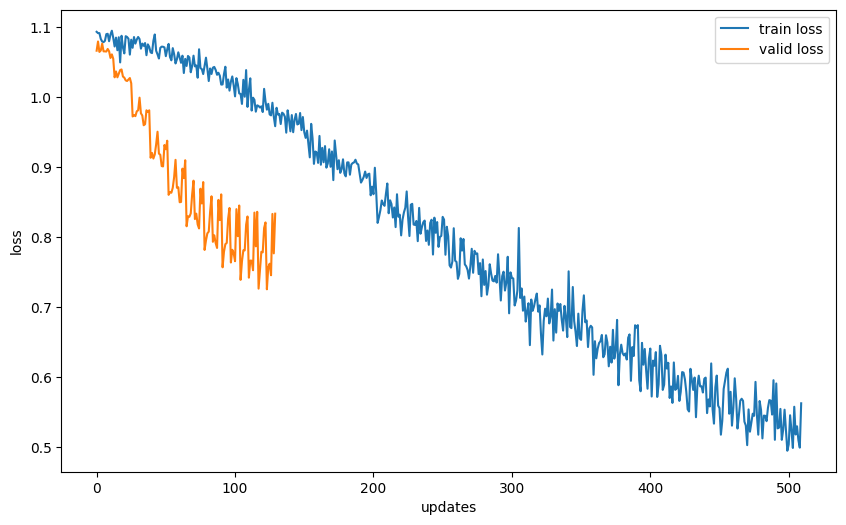

In [ ]:
fig = plt.figure(figsize=(10,6))
ax = fig.add_subplot(1,1,1)
ax.plot(train_losses, label='train loss')
ax.plot(valid_losses, label='valid loss')
plt.legend()
ax.set_xlabel('updates')
ax.set_ylabel('loss');

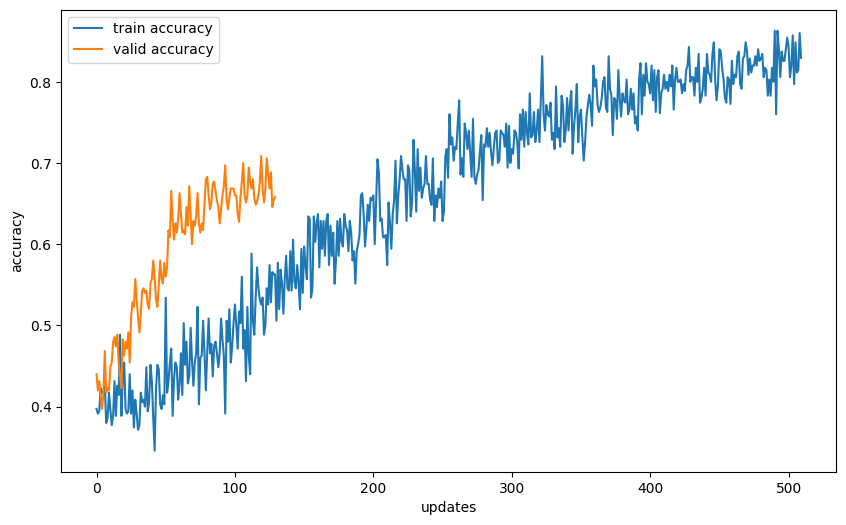

In [ ]:
fig = plt.figure(figsize=(10,6))
ax = fig.add_subplot(1,1,1)
ax.plot(train_accs, label='train accuracy')
ax.plot(valid_accs, label='valid accuracy')
plt.legend()
ax.set_xlabel('updates')
ax.set_ylabel('accuracy');

In [ ]:
model.load_state_dict(torch.load('nbow.pt'))

test_loss, test_acc = evaluate(test_dataloader, model, criterion, device)

epoch_test_loss = np.mean(test_loss)
epoch_test_acc = np.mean(test_acc)

print(f'test_loss: {epoch_test_loss:.3f}, test_acc: {epoch_test_acc:.3f}')

evaluating...: 100%|██████████| 16/16 [00:00<00:00, 141.02it/s]
test_loss: 0.753, test_acc: 0.686


## Pruebas de predicción de sentimientos (9)

Vamos a crear la función que utilizaremos para predecir el sentimiento. Los parametros de entrada son:
* el texto sobre el que predecir el sentimiento
* el modelo que hemos entrenado
* el tokenizador definido
* el vocabulario de nuestro dataset inicial
* el dispositivo donde se ejecuta (cuda/cpu...)

In [ ]:
def predict_sentiment(text, model, tokenizer, vocab, device):
    text = clean_text(text)
    tokens = tokenizer(text)
    ids = [vocab[t] for t in tokens if t in vocab] # imprescindible el if t in vocab porque sino da error si alguna palabra no existe en el vocabulario
    tensor = torch.LongTensor(ids).unsqueeze(dim=0).to(device)
    prediction = model(tensor).squeeze(dim=0)
    probability = torch.softmax(prediction, dim=-1)
    #print(probability)
    #print(probability[prediction.argmax(dim=-1)].item())
    
    if math.isnan(probability[prediction.argmax(dim=-1)].item()): # esto aparece cuando no hay datos, es decir, ninguna palabra en vocab
        print(f'ERROR: \nThere isn\'t enough vocabulary to predict that text... sorry :( \nWe will improve it ;)')
        return ;

    elif probability[prediction.argmax(dim=-1)].item() < 0.6: # si no tiene un porcentaje mayor de 60%, se pone en neutro
        predicted_probability = probability[prediction.argmax(dim=-1).item()].item() # si es neutro "forzado" mantenemos la probabilidad del máximo (duditas de esto)
        predicted_class = 1

    else:
        predicted_class = prediction.argmax(dim=-1).item()
        predicted_probability = probability[predicted_class].item()

    if predicted_class == 0:
        vibes = 'negative vibes'
    elif predicted_class == 1:
        vibes = 'neutral vibes'
    elif predicted_class == 2:
        vibes = 'positive vibes'
    return vibes, predicted_probability
        

In [ ]:
text = "Tomorrow it is going to be a new day"

predict_sentiment(text, model, tokenizer, vocab, device)

('positive vibes', 0.6799032092094421)

In [ ]:
text = "good"

predict_sentiment(text, model, tokenizer, vocab, device)

('positive vibes', 1.0)

In [ ]:
text = "bad"

predict_sentiment(text, model, tokenizer, vocab, device)

('negative vibes', 1.0)

In [ ]:
text = "neutral"

predict_sentiment(text, model, tokenizer, vocab, device)

ERROR: 
There isn't enough vocabulary to predict that text... sorry :( 
We will improve it ;)


In [ ]:
text = "tomorrow its saturday"

predict_sentiment(text, model, tokenizer, vocab, device)

('neutral vibes', 0.47165924310684204)

In [ ]:
text = "I`d have responded, if I were going	"

predict_sentiment(text, model, tokenizer, vocab, device)

('neutral vibes', 0.9408195614814758)

In [ ]:
text = "hello"

predict_sentiment(text, model, tokenizer, vocab, device)

('neutral vibes', 0.9975599050521851)

In [ ]:
text = str(input('texto:'))

predict_sentiment(text, model, tokenizer, vocab, device)

texto:hola
ERROR: 
There isn't enough vocabulary to predict that text... sorry :( 
We will improve it ;)


# Conclusiones

Si volviera a hacer este proyecto:

-  Elegiría un dataset más amplio que solo tuviera sentimientos negativos y positivos para poder tener un modelo más preciso y añadir el sentimiento neutro con umbrales, donde si la diferencia de probabilidad de los sentimientos es menor que 40% (30-70 → 40-60 es < 40 %) entonces el resultado fuese el sentimiento neutro. Además, creo que este dataset no era el más adecuado y me ha limitado en la precisión del modelo.

- Me hubiera centrado en mantener el formato correcto de los datos ya que he tenido que convertirlos justo antes de crear los modelos de entrenamiento, validez y prueba.

También me hubiera gustado implementar un traductor de manera que el texto del que quieres predecir el sentimiento fuera de cualquier idioma y lo tradujese al inglés para predecirlo.